In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# !unzip /content/drive/My\ Drive/gan19_red2white_roses.zip

In [3]:
!nvidia-smi

Fri Jun 19 20:55:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm, tqdm_notebook
import glob
import random
import itertools
import torchvision.utils as vutils
from torchsummary import summary

%matplotlib inline

In [5]:
SEED = 21

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
batch_size = 20
image_size =(128, 128)
epochs = 100
start_epoch = 0
save_weights_path = "/content/drive/My Drive/weights_gan19"
lr = 3e-4

In [11]:
# find out the size of images in dataset
image = Image.open("/content/gan19_red2white_roses/trainA/a0.jpg")
np.array(image).shape

(320, 480, 3)

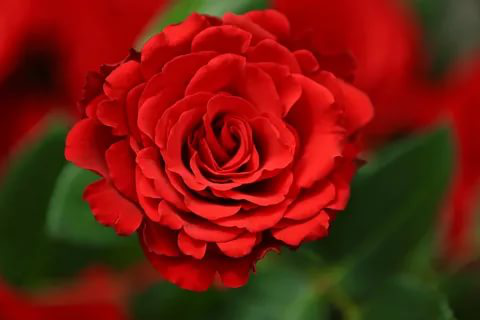

In [12]:
image

In [13]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}A") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}B") + "/*.*"))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [14]:
dataset = ImageDataset(root=os.path.join("/content/", "gan19_red2white_roses"),
                       transform=transforms.Compose([
                           transforms.Resize(image_size, Image.BICUBIC),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ])
                       )
inv_normalize = transforms.Normalize(
    mean=[-1., -1., -1.],
    std=[2., 2., 2.]
)


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [15]:
unloader = transforms.ToPILImage()

def imshow(tensor, title):
    plt.figure()
    
    image = inv_normalize(tensor.cpu().clone())  
    image = unloader(image)
    plt.imshow(image)
    plt.title(title)

In [16]:
len(dataloader)*batch_size

1160

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.last = nn.Conv2d(128, 1, 4, padding=1)

      

    def forward(self, x):
        x = self.main(x)
        x = self.last(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.output(self.upsampling(self.main(x)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels=256):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels))

    def forward(self, x):
        return x + self.res(x)

In [19]:
netG_A2B = Generator().to(device)
netG_B2A = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

In [20]:
# summary(netG_A2B, (3,*image_size))

In [21]:
# summary(netD_A, (3,*image_size))

In [22]:
# # if train broke off need to initialisate NN with weights

name_dataset = 'red2white_roses'
start_epoch = 6
netG_A2B.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netG_A2B_epoch_{start_epoch-1}.pth"))
netG_B2A.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netG_B2A_epoch_{start_epoch-1}.pth"))
netD_A.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netD_A_epoch_{start_epoch-1}.pth"))
netD_B.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netD_B_epoch_{start_epoch-1}.pth"))

<All keys matched successfully>

In [23]:
# losses
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)

In [24]:
# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                               lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [25]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [26]:
decay_epoch = 80
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(epochs, start_epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(epochs, start_epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(epochs, start_epoch, decay_epoch).step)

In [27]:
!nvidia-smi

Fri Jun 19 20:56:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |    877MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


In [29]:
def updateStepDisc(epoch:int):
  # generator will be update every iterate 
  # but discriminator every iter%updateStepDisc(epoch)==0 iterate
  if epoch>70: return 3
  # if epoch>50: return 3
  if epoch>10: return 4
  return 3

In [1]:
g_losses = []
d_losses = []

identity_losses = []
gan_losses = []
cycle_losses = []

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

dataset = "red2white_roses"
print_freq = 20

for epoch in range(start_epoch, epochs):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, data in progress_bar:
        # get batch size data
        real_image_A = data["A"].to(device)
        real_image_B = data["B"].to(device)
        batch_size = real_image_A.size(0)

        # real data label is 1, fake data label is 0.
        real_label = torch.full((batch_size, 1), 1, device=device, dtype=torch.float32)
        fake_label = torch.full((batch_size, 1), 0, device=device, dtype=torch.float32)

        ##############################################
        # (1) Update G network: Generators A2B and B2A
        ##############################################

        # Set G_A and G_B's gradients to zero
        optimizer_G.zero_grad()

        # Identity loss
        # G_B2A(A) should equal A if real A is fed
        identity_image_A = netG_B2A(real_image_A)
        loss_identity_A = identity_loss(identity_image_A, real_image_A) * 5.0
        # G_A2B(B) should equal B if real B is fed
        identity_image_B = netG_A2B(real_image_B)
        loss_identity_B = identity_loss(identity_image_B, real_image_B) * 5.0

        # GAN loss
        # GAN loss D_A(G_A(A))
        fake_image_A = netG_B2A(real_image_B)
        fake_output_A = netD_A(fake_image_A)
        loss_GAN_B2A = adversarial_loss(fake_output_A, real_label)
        # GAN loss D_B(G_B(B))
        fake_image_B = netG_A2B(real_image_A)
        fake_output_B = netD_B(fake_image_B)
        loss_GAN_A2B = adversarial_loss(fake_output_B, real_label)

        # Cycle loss
        recovered_image_A = netG_B2A(fake_image_B)
        loss_cycle_ABA = cycle_loss(recovered_image_A, real_image_A) * 10.0

        recovered_image_B = netG_A2B(fake_image_A)
        loss_cycle_BAB = cycle_loss(recovered_image_B, real_image_B) * 10.0

        # Combined loss and calculate gradients
        errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB

        # Calculate gradients for G_A and G_B
        errG.backward()
        # Update G_A and G_B's weights
        optimizer_G.step()

        ##############################################
        # (2) Update D network: Discriminator A
        ##############################################
        if i%updateStepDisc(epoch)==0:
          # Set D_A gradients to zero
          optimizer_D_A.zero_grad()

          # Real A image loss
          real_output_A = netD_A(real_image_A)
          errD_real_A = adversarial_loss(real_output_A, real_label)

          # Fake A image loss
          fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
          fake_output_A = netD_A(fake_image_A.detach())
          errD_fake_A = adversarial_loss(fake_output_A, fake_label)

          # Combined loss and calculate gradients
          errD_A = (errD_real_A + errD_fake_A) / 2

          # Calculate gradients for D_A
          errD_A.backward()
          # Update D_A weights
          optimizer_D_A.step()

        ##############################################
        # (3) Update D network: Discriminator B
        ##############################################
        if i%updateStepDisc(epoch)==0:
          # Set D_B gradients to zero
          optimizer_D_B.zero_grad()

          # Real B image loss
          real_output_B = netD_B(real_image_B)
          errD_real_B = adversarial_loss(real_output_B, real_label)

          # Fake B image loss
          fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
          fake_output_B = netD_B(fake_image_B.detach())
          errD_fake_B = adversarial_loss(fake_output_B, fake_label)

          # Combined loss and calculate gradients
          errD_B = (errD_real_B + errD_fake_B) / 2

          # Calculate gradients for D_B
          errD_B.backward()
          # Update D_B weights
          optimizer_D_B.step()

        progress_bar.set_description(
            f"[{epoch}/{epochs - 1}][{i}/{len(dataloader) - 1}] "
            f"Loss_D: {(errD_A + errD_B).item():.4f} "
            f"Loss_G: {errG.item():.4f} "
            f"Loss_G_identity: {(loss_identity_A + loss_identity_B).item():.4f} "
            f"loss_G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f} "
            f"loss_G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}")

        if i % print_freq == 0:
            
            
            fake_image_A = netG_B2A(real_image_B).data
            fake_image_B = netG_A2B(real_image_A).data

            imshow(real_image_A[0],"real A")
            imshow(fake_image_B.detach()[0],"fake B")

            imshow(real_image_B[0],"real B")
            imshow(fake_image_A.detach()[0],"fake A")
            
            plt.show()
    # do check pointing

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if epoch%5==0: 
      torch.save(netG_A2B.state_dict(), f"{save_weights_path}/{dataset}/netG_A2B_epoch_{epoch}.pth")
      torch.save(netG_B2A.state_dict(), f"{save_weights_path}/{dataset}/netG_B2A_epoch_{epoch}.pth")
      torch.save(netD_A.state_dict(), f"{save_weights_path}/{dataset}/netD_A_epoch_{epoch}.pth")
      torch.save(netD_B.state_dict(), f"{save_weights_path}/{dataset}/netD_B_epoch_{epoch}.pth")


# save last check pointing
torch.save(netG_A2B.state_dict(), f"{save_weights_path}/{dataset}/netG_A2B.pth")
torch.save(netG_B2A.state_dict(), f"{save_weights_path}/{dataset}/netG_B2A.pth")
torch.save(netD_A.state_dict(), f"{save_weights_path}/{dataset}/netD_A.pth")
torch.save(netD_B.state_dict(), f"{save_weights_path}/{dataset}/netD_B.pth")

NameError: name 'ReplayBuffer' is not defined